In [11]:
import os
import pandas as pd
import numpy as np
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from random import shuffle
import random

from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Concatenate, Reshape, Dropout, Conv2D, MaxPool2D, Flatten, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

In [107]:
SIZE = 50
EPOCHS = 10
BATCH_SIZE = 128

In [3]:
PATH = 'C:/Users/Maedr3/Documents/packt/chapter 7/data/dogs-vs-cats/train/'

In [135]:
def get_input(file):
    return Image.open(PATH+file)

In [122]:
def get_output(file):
    class_label = file.split('.')[0]
    if class_label == 'dog': label_vector = [1,0]
    elif class_label == 'cat': label_vector = [0,1]
    return label_vector

In [19]:
def random_horizontal_flip(image):
    toss = random.randint(1, 2)
    if toss == 1:
        return image.transpose(Image.FLIP_LEFT_RIGHT)
    else:
        return image

In [25]:
def random_rotate(image, rot_range):
    value = random.randint(-rot_range,rot_range)
    return image.rotate(value)

In [173]:
def random_horizontal_shift(image, shift):
    width, height = image.size
    rand_shift = random.randint(0,shift*width)
    image = PIL.ImageChops.offset(image, rand_shift, 0)
    image.paste((0), (0, 0, rand_shift, height))
    return image

In [174]:
def random_vertical_shift(image, shift):
    width, height = image.size
    rand_shift = random.randint(0,shift*height)
    image = PIL.ImageChops.offset(image, 0, rand_shift)
    image.paste((0), (0, 0, width, rand_shift))
    return image

In [196]:
def preprocess_input(image):
    
    # Data preprocessing
    image = image.convert('L')
    image = image.resize((SIZE,SIZE))
    
    
    # Data augmentation
    random_vertical_shift(image, shift=0.2)
    random_horizontal_shift(image, shift=0.2)
    random_rotate(image, rot_range=45)
    random_horizontal_flip(image)
    
    return np.array(image).reshape(SIZE,SIZE,1)

In [225]:
def custom_image_generator(images, batch_size = 128):
    
    while True:
        # Randomly select images for the batch
        batch_images = np.random.choice(images, size = batch_size)
        batch_input = []
        batch_output = [] 
        
        # Read image, perform preprocessing and get labels
        for file in batch_images:
            # Function that reads and returns the image
            input_image = get_input(file)
            # Function that gets the label of the image
            label = get_output(file)
            # Function that pre-processes and augments the image
            image = preprocess_input(input_image)

            batch_input.append(image)
            batch_output.append(label)

        batch_x = np.array(batch_input)
        batch_y = np.array(batch_output)

        # Return a tuple of (images,labels) to feed the network
        yield(batch_x, batch_y)


In [212]:
def get_label(file):
    class_label = file.split('.')[0]
    if class_label == 'dog': label_vector = [1,0]
    elif class_label == 'cat': label_vector = [0,1]
    return label_vector

In [219]:
def get_data(files):
    data_image = []
    labels = []
    for image in tqdm(files):
        
        label_vector = get_label(image)
        

        img = Image.open(PATH + image).convert('L')
        img = img.resize((SIZE,SIZE))
        
       
        labels.append(label_vector)
        data_image.append(np.asarray(img).reshape(SIZE,SIZE,1))
        
    data_x = np.array(data_image)
    data_y = np.array(labels)
        
    return (data_x, data_y)

In [71]:
files = os.listdir(PATH)

In [102]:
random.shuffle(files)

In [103]:
train = files[:7000]
test = files[7000:]

In [221]:
validation_data = get_data(test)

100%|██████████| 3000/3000 [00:14<00:00, 208.86it/s]


In [246]:
model = Sequential()
    
model.add(Conv2D(48, (3, 3), activation='relu', padding='same', input_shape=(50,50,1)))    
model.add(Conv2D(48, (3, 3), activation='relu'))    
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.10))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 50, 50, 48)        480       
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 48, 48, 48)        20784     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 24, 24, 48)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 24, 24, 48)        192       
_________________________________________________________________
dropout_17 (Dropout)         (None, 24, 24, 48)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 27648)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 512)               14156288  
__________

In [247]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics = ['accuracy'])

In [248]:
model_details = model.fit_generator(custom_image_generator(train, batch_size = BATCH_SIZE),
                    steps_per_epoch = len(train) // BATCH_SIZE, 
                    epochs = EPOCHS, 
                    validation_data= validation_data,
                    verbose=1)

Epoch 1/10
54/54 [==============================] - ETA: 5:59 - loss: 1.1141 - acc: 0.523 - ETA: 4:24 - loss: 2.9537 - acc: 0.550 - ETA: 3:45 - loss: 3.5541 - acc: 0.559 - ETA: 3:23 - loss: 4.1811 - acc: 0.548 - ETA: 3:07 - loss: 4.3504 - acc: 0.567 - ETA: 2:57 - loss: 4.5880 - acc: 0.565 - ETA: 2:49 - loss: 4.8751 - acc: 0.560 - ETA: 2:42 - loss: 5.0331 - acc: 0.563 - ETA: 2:35 - loss: 4.9632 - acc: 0.576 - ETA: 2:29 - loss: 5.0130 - acc: 0.577 - ETA: 2:24 - loss: 4.9764 - acc: 0.578 - ETA: 2:19 - loss: 4.9582 - acc: 0.578 - ETA: 2:14 - loss: 4.8841 - acc: 0.581 - ETA: 2:11 - loss: 4.7889 - acc: 0.584 - ETA: 2:07 - loss: 4.6483 - acc: 0.589 - ETA: 2:03 - loss: 4.5476 - acc: 0.588 - ETA: 1:59 - loss: 4.5345 - acc: 0.581 - ETA: 1:56 - loss: 4.4124 - acc: 0.582 - ETA: 1:52 - loss: 4.3171 - acc: 0.583 - ETA: 1:48 - loss: 4.2261 - acc: 0.584 - ETA: 1:44 - loss: 4.1233 - acc: 0.587 - ETA: 1:41 - loss: 4.0010 - acc: 0.591 - ETA: 1:37 - loss: 3.9068 - acc: 0.593 - ETA: 1:34 - loss: 3.8014 - a

54/54 [==============================] - ETA: 2:18 - loss: 0.2038 - acc: 0.921 - ETA: 2:21 - loss: 0.1998 - acc: 0.929 - ETA: 2:19 - loss: 0.1817 - acc: 0.934 - ETA: 2:16 - loss: 0.1696 - acc: 0.939 - ETA: 2:14 - loss: 0.1768 - acc: 0.937 - ETA: 2:10 - loss: 0.1742 - acc: 0.938 - ETA: 2:07 - loss: 0.1653 - acc: 0.943 - ETA: 2:05 - loss: 0.1720 - acc: 0.940 - ETA: 2:02 - loss: 0.1705 - acc: 0.940 - ETA: 2:00 - loss: 0.1671 - acc: 0.941 - ETA: 1:57 - loss: 0.1637 - acc: 0.941 - ETA: 1:54 - loss: 0.1635 - acc: 0.940 - ETA: 1:51 - loss: 0.1593 - acc: 0.942 - ETA: 1:48 - loss: 0.1582 - acc: 0.941 - ETA: 1:46 - loss: 0.1557 - acc: 0.942 - ETA: 1:43 - loss: 0.1574 - acc: 0.942 - ETA: 1:40 - loss: 0.1557 - acc: 0.943 - ETA: 1:37 - loss: 0.1558 - acc: 0.943 - ETA: 1:34 - loss: 0.1572 - acc: 0.942 - ETA: 1:32 - loss: 0.1543 - acc: 0.944 - ETA: 1:29 - loss: 0.1545 - acc: 0.943 - ETA: 1:27 - loss: 0.1539 - acc: 0.943 - ETA: 1:24 - loss: 0.1507 - acc: 0.944 - ETA: 1:21 - loss: 0.1483 - acc: 0.946 -

In [250]:
score = model.evaluate(validation_data[0], validation_data[1])

3000/3000 [==============================] - ETA: 13 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 14 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 13 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 12 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 11 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 10 - ETA: 9 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 19s 6ms/step


In [251]:
print("Accuracy: {0:.2f}%".format(score[1]*100))

Accuracy: 72.57%


In [252]:
y_pred = model.predict(validation_data[0])

In [253]:
correct_indices = np.nonzero(np.argmax(y_pred,axis=1) == np.argmax(validation_data[1],axis=1))[0]
incorrect_indices = np.nonzero(np.argmax(y_pred,axis=1) != np.argmax(validation_data[1],axis=1))[0]

In [254]:
labels = ['dog', 'cat']

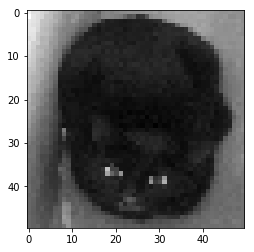

Prediction: dog


In [261]:
image = 7
plt.imshow(validation_data[0][incorrect_indices[image]].reshape(50,50), cmap=plt.get_cmap('gray'))
plt.show()
print("Prediction: {0}".format(labels[np.argmax(y_pred[incorrect_indices[image]])]))

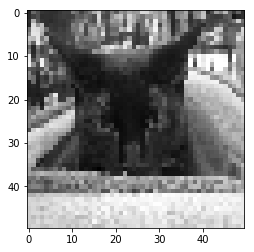

Prediction: cat


In [256]:
image = 3
plt.imshow(validation_data[0][correct_indices[image]].reshape(50,50), cmap=plt.get_cmap('gray'))
plt.show()
print("Prediction: {0}".format(labels[np.argmax(y_pred[correct_indices[image]])]))